In [1]:

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.optimizers import SGD
from keras.optimizers import adam
from tensorflow.keras import layers
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.regularizers import l1
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder






In [2]:
k=pd.read_csv("dataset-HAR-PUC-Rio.csv",delimiter=";")

C:\Users\giorgospc\AppData\Local\Temp\ipykernel_9332\2729528174.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  k=pd.read_csv("dataset-HAR-PUC-Rio.csv",delimiter=";")


In [3]:
k.head()

,user,gender,age,how_tall_in_meters,weight,body_mass_index,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4,class
0,debora,Woman,46,"1,62",75,"28,6",-3,92,-63,-23,18,-19,5,104,-92,-150,-103,-147,sitting
1,debora,Woman,46,"1,62",75,"28,6",-3,94,-64,-21,18,-18,-14,104,-90,-149,-104,-145,sitting
2,debora,Woman,46,"1,62",75,"28,6",-1,97,-61,-12,20,-15,-13,104,-90,-151,-104,-144,sitting
3,debora,Woman,46,"1,62",75,"28,6",-2,96,-57,-15,21,-16,-13,104,-89,-153,-103,-142,sitting
4,debora,Woman,46,"1,62",75,"28,6",-1,96,-61,-13,20,-15,-13,104,-89,-153,-104,-143,sitting


Inspecting the dataframe, the columns that contain numerical data contain "," instead of "." , also it would be usefull to convert the numerical data into floats, At first we clean the dataframe from any unwanted symbols and turn the numerical data into floats using a simple function that applies regex to these columns.

In [4]:


# columns that arent numerical
categorical_cols = ['user', 'gender', 'class']

# candidate columns = all columns except non numerical
candidates = [c for c in k.columns if c not in categorical_cols]


def convert_numeric_series(s):
    """Check for %, commas , (), convert values that look numerical to floats"""
    s = s.astype(str).fillna('').str.strip()

    s = s.str.replace(r'^\((.*)\)$', r'-\1', regex=True)

    # % if found at the end ,strip 
    is_percent = s.str.endswith('%')
    s = s.str.replace('%', '', regex=False)

    # remove any characters except digits, dot, comma, minus
    s = s.str.replace(r'[^\d\-\.,]', '', regex=True)

    # handle numbers that contain both '.' and ',' -> assume '.' thousands and ',' decimal:
    has_dot = s.str.contains(r'\.', regex=True)
    has_comma = s.str.contains(',', regex=True)
    both_mask = has_dot & has_comma

    s_both = s[both_mask].str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
    s_only_comma = s[~has_dot & has_comma].str.replace(',', '.', regex=False)
    s_only_dot = s[has_dot & ~has_comma]  # leave as-is

    # combine back
    s_clean = s.copy()
    s_clean[both_mask] = s_both
    s_clean[~has_dot & has_comma] = s_only_comma
    s_clean[has_dot & ~has_comma] = s_only_dot

    # remove accidental multiple dots or leading/trailing dots
    s_clean = s_clean.str.replace(r'\.+', '.', regex=True).str.replace(r'^\.$', '', regex=True)

    # convert to numeric (coerce unconvertible -> NaN)
    numeric = pd.to_numeric(s_clean.replace('', np.nan), errors='coerce')

    # apply percent transform
    if is_percent.any():
        numeric[is_percent] = numeric[is_percent] / 100.0

    return numeric


In [ ]:
# Apply conversion with a simple success-ratio check
converted_cols = []
for col in candidates:
    converted = convert_numeric_series(k[col])
    success_ratio = converted.notna().mean()
    print(f"Column '{col}': conversion success {success_ratio:.1%}")
    # decide threshold for replacing column
    if success_ratio >= 0.5:           
        k[col] = converted.astype('float64')
        converted_cols.append(col)
    else:
        # don't replace 
        print(f"  -> skipped replacing '{col}' automatically (low numeric parse rate).")

print("Automatically converted columns:", converted_cols)

# Quick checks:
print(k[converted_cols].dtypes)                
for c in converted_cols:
    # show some rows that failed to convert (if any)
    n_failed = k[c].isna().sum()
    if n_failed:
        print(f"Column {c} has {n_failed} NaNs after conversion; sample bad values:")
        print(k.loc[k[c].isna(), c].head(10))

Column 'age': conversion success 100.0%
Column 'how_tall_in_meters': conversion success 100.0%
Column 'weight': conversion success 100.0%
Column 'body_mass_index': conversion success 100.0%
Column 'x1': conversion success 100.0%
Column 'y1': conversion success 100.0%
Column 'z1': conversion success 100.0%
Column 'x2': conversion success 100.0%
Column 'y2': conversion success 100.0%
Column 'z2': conversion success 100.0%
Column 'x3': conversion success 100.0%
Column 'y3': conversion success 100.0%
Column 'z3': conversion success 100.0%
Column 'x4': conversion success 100.0%
Column 'y4': conversion success 100.0%
Column 'z4': conversion success 100.0%
Automatically converted columns: ['age', 'how_tall_in_meters', 'weight', 'body_mass_index', 'x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4']
age                   float64
how_tall_in_meters    float64
weight                float64
body_mass_index       float64
x1                    float64
y1                    float6

In [6]:
k

,user,gender,age,how_tall_in_meters,weight,body_mass_index,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4,class
0,debora,Woman,46.0,1.62,75.0,28.6,-3.0,92.0,-63.0,-23.0,18.0,-19.0,5.0,104.0,-92.0,-150.0,-103.0,-147.0,sitting
1,debora,Woman,46.0,1.62,75.0,28.6,-3.0,94.0,-64.0,-21.0,18.0,-18.0,-14.0,104.0,-90.0,-149.0,-104.0,-145.0,sitting
2,debora,Woman,46.0,1.62,75.0,28.6,-1.0,97.0,-61.0,-12.0,20.0,-15.0,-13.0,104.0,-90.0,-151.0,-104.0,-144.0,sitting
3,debora,Woman,46.0,1.62,75.0,28.6,-2.0,96.0,-57.0,-15.0,21.0,-16.0,-13.0,104.0,-89.0,-153.0,-103.0,-142.0,sitting
4,debora,Woman,46.0,1.62,75.0,28.6,-1.0,96.0,-61.0,-13.0,20.0,-15.0,-13.0,104.0,-89.0,-153.0,-104.0,-143.0,sitting
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165628,jose_carlos,Man,75.0,1.67,67.0,24.0,2.0,93.0,-148.0,-8.0,88.0,-100.0,15.0,120.0,-100.0,-189.0,-77.0,-160.0,walking
165629,jose_carlos,Man,75.0,1.67,67.0,24.0,-1.0,94.0,-147.0,-17.0,87.0,-99.0,17.0,121.0,-99.0,-190.0,-78.0,-158.0,walking
165630,jose_carlos,Man,75.0,1.67,67.0,24.0,-10.0,93.0,-143.0,-19.0,86.0,-104.0,0.0,114.0,-101.0,-185.0,-80.0,-153.0,walking
165631,jose_carlos,Man,75.0,1.67,67.0,24.0,-15.0,86.0,-152.0,-19.0,88.0,-117.0,-44.0,155.0,-25.0,-185.0,-84.0,-156.0,walking


In [7]:
k.dtypes
k.isna().sum()

user                  0
gender                0
age                   0
how_tall_in_meters    0
weight                0
body_mass_index       0
x1                    0
y1                    0
z1                    0
x2                    0
y2                    0
z2                    0
x3                    0
y3                    0
z3                    0
x4                    0
y4                    0
z4                    1
class                 0
dtype: int64

In [8]:
k['z4'].fillna(0, inplace=True)

In [9]:
k.dtypes
k.isna().sum()

user                  0
gender                0
age                   0
how_tall_in_meters    0
weight                0
body_mass_index       0
x1                    0
y1                    0
z1                    0
x2                    0
y2                    0
z2                    0
x3                    0
y3                    0
z3                    0
x4                    0
y4                    0
z4                    0
class                 0
dtype: int64

In [10]:
k.head()

,user,gender,age,how_tall_in_meters,weight,body_mass_index,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4,class
0,debora,Woman,46.0,1.62,75.0,28.6,-3.0,92.0,-63.0,-23.0,18.0,-19.0,5.0,104.0,-92.0,-150.0,-103.0,-147.0,sitting
1,debora,Woman,46.0,1.62,75.0,28.6,-3.0,94.0,-64.0,-21.0,18.0,-18.0,-14.0,104.0,-90.0,-149.0,-104.0,-145.0,sitting
2,debora,Woman,46.0,1.62,75.0,28.6,-1.0,97.0,-61.0,-12.0,20.0,-15.0,-13.0,104.0,-90.0,-151.0,-104.0,-144.0,sitting
3,debora,Woman,46.0,1.62,75.0,28.6,-2.0,96.0,-57.0,-15.0,21.0,-16.0,-13.0,104.0,-89.0,-153.0,-103.0,-142.0,sitting
4,debora,Woman,46.0,1.62,75.0,28.6,-1.0,96.0,-61.0,-13.0,20.0,-15.0,-13.0,104.0,-89.0,-153.0,-104.0,-143.0,sitting


In [11]:
# The user column and gender will be droped(No actual value to training)
# Column class is the output 

TARGET='class'
drop_user = ['user']
gender_one_hot = ['gender']

# Create Input for the NN

X = k.drop(columns=[TARGET])

y = k[TARGET]

# feature lists
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
# remove any columns we plan to drop
num_cols = [c for c in num_cols if c not in drop_user + [TARGET]]
cat_cols = [c for c in gender_one_hot if c in X.columns]

print("Numerical cols:", num_cols)
print("Categorical cols:", cat_cols)

Numerical cols: ['age', 'how_tall_in_meters', 'weight', 'body_mass_index', 'x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4']
Categorical cols: ['gender']


In [13]:
X.head()

,user,gender,age,how_tall_in_meters,weight,body_mass_index,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4
0,debora,Woman,46.0,1.62,75.0,28.6,-3.0,92.0,-63.0,-23.0,18.0,-19.0,5.0,104.0,-92.0,-150.0,-103.0,-147.0
1,debora,Woman,46.0,1.62,75.0,28.6,-3.0,94.0,-64.0,-21.0,18.0,-18.0,-14.0,104.0,-90.0,-149.0,-104.0,-145.0
2,debora,Woman,46.0,1.62,75.0,28.6,-1.0,97.0,-61.0,-12.0,20.0,-15.0,-13.0,104.0,-90.0,-151.0,-104.0,-144.0
3,debora,Woman,46.0,1.62,75.0,28.6,-2.0,96.0,-57.0,-15.0,21.0,-16.0,-13.0,104.0,-89.0,-153.0,-103.0,-142.0
4,debora,Woman,46.0,1.62,75.0,28.6,-1.0,96.0,-61.0,-13.0,20.0,-15.0,-13.0,104.0,-89.0,-153.0,-104.0,-143.0


In [14]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=40, shuffle=True
)

# ------------- preprocess -------------
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols),
], remainder='drop') 

# fit-transform training data
preprocessor.fit(X_train)
X_train_proc = preprocessor.transform(X_train).astype('float32')
X_test_proc  = preprocessor.transform(X_test).astype('float32')

# ------------- encode target -------------
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)
num_classes = len(le.classes_)
y_train_ohe = tf.keras.utils.to_categorical(y_train_enc, num_classes)
y_test_ohe  = tf.keras.utils.to_categorical(y_test_enc, num_classes)


c:\Users\giorgospc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# 0. quick info
print("n samples:", len(k))
print("n users:", k['user'].nunique())
print("class counts:\n", k['class'].value_counts())

# 1. per-user class distribution (very important)
print("\nPer-user class counts (top users):")
print(k.groupby('user')['class'].value_counts().unstack(fill_value=0).head(20))

# 2. check duplicates exact matches
dups = k.duplicated(subset=[c for c in k.columns if c!='class'], keep=False)  # duplicates ignoring class
print("\nExact duplicate rows (ignoring class) count:", dups.sum())
# check if identical rows exist across different classes or split
print(k[dups].head())

# 3. check if any rows in test equal rows in train (if you still have X_train/X_test)
train_df = X_train.copy()
test_df  = X_test.copy()
# if you don't have user col in X_train/X_test, use original indexed subsets instead:
common = pd.merge(train_df.reset_index(), test_df.reset_index(), how='inner', on=train_df.columns.tolist())
print("\nExact common rows between train and test:", len(common))

# 4. look for features with zero or near-zero variance
stds = X.describe().T['std']
print("\nZero / near-zero variance features:\n", stds[stds < 1e-6])

# 5. quick single-feature predictive test (train a simple tree on raw X)
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
dt = DecisionTreeClassifier(max_depth=3, random_state=0)
dt.fit(X_train_proc, y_train_ohe)
print("\nDecisionTree (max_depth=3) acc on test:", accuracy_score(y_test, dt.predict(X_test)))

# 6. feature importance / univariate stats
from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(X.fillna(0), k['class'])
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print("\nTop mutual-info features:\n", mi_series.head(10))

n samples: 165633
n users: 4
class counts:
 sitting        50631
standing       47370
walking        43390
standingup     12415
sittingdown    11827
Name: class, dtype: int64

Per-user class counts (top users):
class        sitting  sittingdown  standing  standingup  walking
user                                                            
debora         15615         3547     14940        3853    13622
jose_carlos     5743          777      3729         737     2175
katia          14280         4017     14234        3710    13556
wallace        14993         3486     14467        4115    14037

Exact duplicate rows (ignoring class) count: 2465
        user gender   age  how_tall_in_meters  weight  body_mass_index   x1  \
1367  debora  Woman  46.0                1.62    75.0             28.6  0.0   
1373  debora  Woman  46.0                1.62    75.0             28.6 -1.0   
1385  debora  Woman  46.0                1.62    75.0             28.6 -1.0   
1469  debora  Woman  46.0       

ValueError: could not convert string to float: 'debora'

In [17]:
input_shape = X_train_proc.shape[1]
model = keras.Sequential([
    layers.Input(shape=(input_shape,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2432      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 11,013
Trainable params: 11,013
Non-trainable params: 0
_________________________________________________________________


In [19]:
callbacks = [keras.callbacks.EarlyStopping(monitor='loss', patience=7, restore_best_weights=True)]
history = model.fit(X_train_proc, y_train_ohe,
                    epochs=100,
                    batch_size=32,
                    callbacks=callbacks,
                    verbose=2)

Epoch 1/100
4659/4659 - 4s - loss: 0.0505 - accuracy: 0.9848 - 4s/epoch - 925us/step
Epoch 2/100
4659/4659 - 4s - loss: 0.0480 - accuracy: 0.9853 - 4s/epoch - 917us/step
Epoch 3/100
4659/4659 - 4s - loss: 0.0476 - accuracy: 0.9851 - 4s/epoch - 907us/step
Epoch 4/100
4659/4659 - 4s - loss: 0.0457 - accuracy: 0.9857 - 4s/epoch - 892us/step
Epoch 5/100
4659/4659 - 4s - loss: 0.0443 - accuracy: 0.9865 - 4s/epoch - 897us/step
Epoch 6/100
4659/4659 - 4s - loss: 0.0431 - accuracy: 0.9865 - 4s/epoch - 897us/step
Epoch 7/100
4659/4659 - 4s - loss: 0.0423 - accuracy: 0.9868 - 4s/epoch - 903us/step
Epoch 8/100
4659/4659 - 4s - loss: 0.0407 - accuracy: 0.9877 - 4s/epoch - 890us/step
Epoch 9/100
4659/4659 - 4s - loss: 0.0415 - accuracy: 0.9875 - 4s/epoch - 917us/step
Epoch 10/100
4659/4659 - 4s - loss: 0.0401 - accuracy: 0.9876 - 4s/epoch - 899us/step
Epoch 11/100
4659/4659 - 4s - loss: 0.0395 - accuracy: 0.9879 - 4s/epoch - 903us/step
Epoch 12/100
4659/4659 - 4s - loss: 0.0390 - accuracy: 0.9877 -

518/518 [==============================] - 0s 595us/step
Test accuracy: 0.9944457860420188

Classification report (labels are encoded integers):

              precision    recall  f1-score   support

     sitting       1.00      1.00      1.00      5091
 sittingdown       0.99      0.97      0.98      1235
    standing       1.00      1.00      1.00      4749
  standingup       0.97      0.98      0.98      1196
     walking       0.99      1.00      0.99      4293

    accuracy                           0.99     16564
   macro avg       0.99      0.99      0.99     16564
weighted avg       0.99      0.99      0.99     16564

Confusion matrix:
 [[5089    0    0    2    0]
 [   1 1202    8   19    5]
 [   0    0 4730    5   14]
 [   4    7    2 1178    5]
 [   0    2    9    9 4273]]


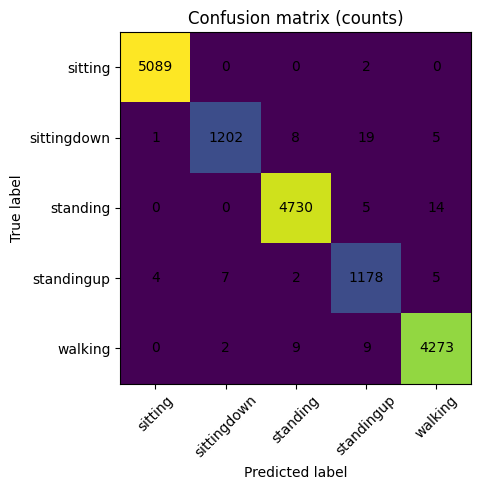

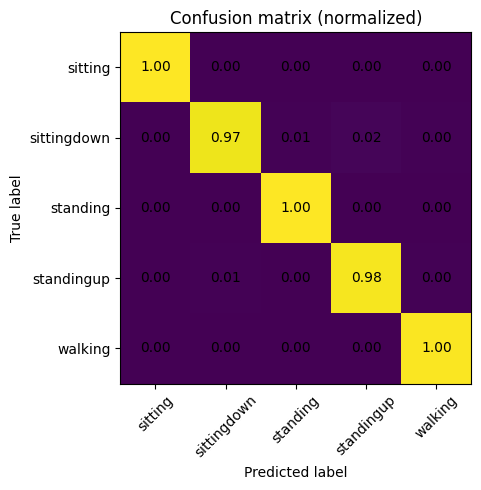

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools
# --- predict on test set ---
y_pred_proba = model.predict(X_test_proc)                # shape (n_samples, n_classes)
y_pred_enc = np.argmax(y_pred_proba, axis=1)
y_true_enc = y_test_enc                                  # from pipeline

# --- overall accuracy and classification report ---
acc = accuracy_score(y_true_enc, y_pred_enc)
print("Test accuracy:", acc)
print("\nClassification report (labels are encoded integers):\n")
print(classification_report(y_true_enc, y_pred_enc, target_names=le.classes_))

# --- confusion matrix and plot ---
cm = confusion_matrix(y_true_enc, y_pred_enc)
print("Confusion matrix:\n", cm)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cm_sum = cm.sum(axis=1)[:, np.newaxis]
        cm = cm.astype('float') / np.where(cm_sum==0, 1, cm_sum)
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 verticalalignment="center",
                 fontsize=10)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, le.classes_, normalize=False, title='Confusion matrix (counts)')
plot_confusion_matrix(cm, le.classes_, normalize=True, title='Confusion matrix (normalized)')

In [24]:

from sklearn.model_selection import StratifiedKFold

n_splits = 5
random_state = 42

X_all = k.drop(columns=['class','user'], errors='ignore')   # features
y_all = k['class'].values                                             # labels (strings)

# Numeric / categorical for ColumnTransformer
num_cols = X_all.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_all.columns if X_all[c].dtype == 'object' and c not in ['user','class']]

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols),
], remainder='drop')

def make_model(input_dim, num_classes):
    model = keras.Sequential([
        keras.layers.Input(shape=(input_dim,)),
        keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-3)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-3)),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
fold = 0
keras_accs = []
for train_idx, test_idx in skf.split(X_all, y_all):
    fold += 1
    print(f"\n=== Fold {fold} / {n_splits} ===")
    X_train = X_all.iloc[train_idx].copy()
    X_test  = X_all.iloc[test_idx].copy()
    y_train = y_all[train_idx]
    y_test  = y_all[test_idx]

    # Fit preprocessor on TRAIN 
    preprocessor.fit(X_train)
    X_train_proc = preprocessor.transform(X_train).astype('float32')
    X_test_proc  = preprocessor.transform(X_test).astype('float32')

    # Encode labels per-fold
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_test_enc  = le.transform(y_test)
    num_classes = len(le.classes_)
    y_train_ohe = tf.keras.utils.to_categorical(y_train_enc, num_classes)

    # Build & train model
    model = make_model(X_train_proc.shape[1], num_classes)
    callbacks = [keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)]
    history = model.fit(X_train_proc, y_train_ohe,
                        epochs=100,
                        batch_size=64,
                        callbacks=callbacks,
                        verbose=2)

    # Evaluate
    y_pred = np.argmax(model.predict(X_test_proc), axis=1)
    acc = accuracy_score(y_test_enc, y_pred)
    keras_accs.append(acc)
    print(f"Fold {fold} accuracy: {acc:.4f}")
    print("Classification report (fold %d):" % fold)
    print(classification_report(y_test_enc, y_pred, target_names=le.classes_))
    print("Confusion matrix (fold %d):" % fold)
    print(confusion_matrix(y_test_enc, y_pred))

print("\nKeras per-fold accuracies:", np.round(keras_accs, 4))
print("Keras mean accuracy: %.4f  std: %.4f" % (np.mean(keras_accs), np.std(keras_accs)))


=== Fold 1 / 5 ===


c:\Users\giorgospc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/100
2071/2071 - 3s - loss: 1.4622 - accuracy: 0.5401 - 3s/epoch - 2ms/step
Epoch 2/100
2071/2071 - 3s - loss: 1.0395 - accuracy: 0.7297 - 3s/epoch - 1ms/step
Epoch 3/100
2071/2071 - 3s - loss: 0.8661 - accuracy: 0.7744 - 3s/epoch - 1ms/step
Epoch 4/100
2071/2071 - 3s - loss: 0.7643 - accuracy: 0.8039 - 3s/epoch - 2ms/step
Epoch 5/100
2071/2071 - 3s - loss: 0.6963 - accuracy: 0.8258 - 3s/epoch - 2ms/step
Epoch 6/100
2071/2071 - 3s - loss: 0.6465 - accuracy: 0.8423 - 3s/epoch - 1ms/step
Epoch 7/100
2071/2071 - 3s - loss: 0.6055 - accuracy: 0.8574 - 3s/epoch - 2ms/step
Epoch 8/100
2071/2071 - 3s - loss: 0.5725 - accuracy: 0.8696 - 3s/epoch - 1ms/step
Epoch 9/100
2071/2071 - 3s - loss: 0.5449 - accuracy: 0.8786 - 3s/epoch - 1ms/step
Epoch 10/100
2071/2071 - 3s - loss: 0.5243 - accuracy: 0.8864 - 3s/epoch - 1ms/step
Epoch 11/100
2071/2071 - 3s - loss: 0.5015 - accuracy: 0.8940 - 3s/epoch - 1ms/step
Epoch 12/100
2071/2071 - 3s - loss: 0.4848 - accuracy: 0.8991 - 3s/epoch - 1ms/step
E

c:\Users\giorgospc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


2071/2071 - 4s - loss: 1.4521 - accuracy: 0.5361 - 4s/epoch - 2ms/step
Epoch 2/100
2071/2071 - 3s - loss: 1.0472 - accuracy: 0.7256 - 3s/epoch - 2ms/step
Epoch 3/100
2071/2071 - 3s - loss: 0.8759 - accuracy: 0.7751 - 3s/epoch - 2ms/step
Epoch 4/100
2071/2071 - 3s - loss: 0.7746 - accuracy: 0.8027 - 3s/epoch - 2ms/step
Epoch 5/100
2071/2071 - 3s - loss: 0.7072 - accuracy: 0.8222 - 3s/epoch - 2ms/step
Epoch 6/100
2071/2071 - 3s - loss: 0.6576 - accuracy: 0.8389 - 3s/epoch - 2ms/step
Epoch 7/100
2071/2071 - 4s - loss: 0.6215 - accuracy: 0.8507 - 4s/epoch - 2ms/step
Epoch 8/100
2071/2071 - 3s - loss: 0.5888 - accuracy: 0.8619 - 3s/epoch - 2ms/step
Epoch 9/100
2071/2071 - 3s - loss: 0.5617 - accuracy: 0.8720 - 3s/epoch - 2ms/step
Epoch 10/100
2071/2071 - 3s - loss: 0.5370 - accuracy: 0.8795 - 3s/epoch - 2ms/step
Epoch 11/100
2071/2071 - 3s - loss: 0.5153 - accuracy: 0.8881 - 3s/epoch - 2ms/step
Epoch 12/100
2071/2071 - 3s - loss: 0.4964 - accuracy: 0.8937 - 3s/epoch - 2ms/step
Epoch 13/100


c:\Users\giorgospc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/100
2071/2071 - 3s - loss: 1.4362 - accuracy: 0.5484 - 3s/epoch - 2ms/step
Epoch 2/100
2071/2071 - 3s - loss: 1.0364 - accuracy: 0.7264 - 3s/epoch - 2ms/step
Epoch 3/100
2071/2071 - 3s - loss: 0.8714 - accuracy: 0.7706 - 3s/epoch - 2ms/step
Epoch 4/100
2071/2071 - 3s - loss: 0.7718 - accuracy: 0.7994 - 3s/epoch - 2ms/step
Epoch 5/100
2071/2071 - 3s - loss: 0.7041 - accuracy: 0.8219 - 3s/epoch - 2ms/step
Epoch 6/100
2071/2071 - 3s - loss: 0.6531 - accuracy: 0.8399 - 3s/epoch - 2ms/step
Epoch 7/100
2071/2071 - 3s - loss: 0.6149 - accuracy: 0.8526 - 3s/epoch - 2ms/step
Epoch 8/100
2071/2071 - 3s - loss: 0.5796 - accuracy: 0.8654 - 3s/epoch - 2ms/step
Epoch 9/100
2071/2071 - 3s - loss: 0.5525 - accuracy: 0.8745 - 3s/epoch - 2ms/step
Epoch 10/100
2071/2071 - 3s - loss: 0.5279 - accuracy: 0.8831 - 3s/epoch - 2ms/step
Epoch 11/100
2071/2071 - 4s - loss: 0.5049 - accuracy: 0.8915 - 4s/epoch - 2ms/step
Epoch 12/100
2071/2071 - 3s - loss: 0.4868 - accuracy: 0.8973 - 3s/epoch - 2ms/step
E

c:\Users\giorgospc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/100
2071/2071 - 4s - loss: 1.4377 - accuracy: 0.5355 - 4s/epoch - 2ms/step
Epoch 2/100
2071/2071 - 3s - loss: 1.0477 - accuracy: 0.7244 - 3s/epoch - 2ms/step
Epoch 3/100
2071/2071 - 3s - loss: 0.8802 - accuracy: 0.7729 - 3s/epoch - 2ms/step
Epoch 4/100
2071/2071 - 3s - loss: 0.7781 - accuracy: 0.8008 - 3s/epoch - 2ms/step
Epoch 5/100
2071/2071 - 3s - loss: 0.7099 - accuracy: 0.8223 - 3s/epoch - 2ms/step
Epoch 6/100
2071/2071 - 3s - loss: 0.6591 - accuracy: 0.8390 - 3s/epoch - 2ms/step
Epoch 7/100
2071/2071 - 3s - loss: 0.6189 - accuracy: 0.8538 - 3s/epoch - 2ms/step
Epoch 8/100
2071/2071 - 3s - loss: 0.5852 - accuracy: 0.8645 - 3s/epoch - 2ms/step
Epoch 9/100
2071/2071 - 3s - loss: 0.5565 - accuracy: 0.8755 - 3s/epoch - 2ms/step
Epoch 10/100
2071/2071 - 3s - loss: 0.5319 - accuracy: 0.8846 - 3s/epoch - 2ms/step
Epoch 11/100
2071/2071 - 3s - loss: 0.5113 - accuracy: 0.8920 - 3s/epoch - 2ms/step
Epoch 12/100
2071/2071 - 3s - loss: 0.4901 - accuracy: 0.8975 - 3s/epoch - 2ms/step
E

c:\Users\giorgospc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/100
2071/2071 - 3s - loss: 1.4664 - accuracy: 0.5237 - 3s/epoch - 2ms/step
Epoch 2/100
2071/2071 - 3s - loss: 1.0388 - accuracy: 0.7288 - 3s/epoch - 2ms/step
Epoch 3/100
2071/2071 - 3s - loss: 0.8726 - accuracy: 0.7728 - 3s/epoch - 2ms/step
Epoch 4/100
2071/2071 - 3s - loss: 0.7718 - accuracy: 0.8029 - 3s/epoch - 2ms/step
Epoch 5/100
2071/2071 - 3s - loss: 0.7013 - accuracy: 0.8253 - 3s/epoch - 2ms/step
Epoch 6/100
2071/2071 - 3s - loss: 0.6503 - accuracy: 0.8428 - 3s/epoch - 2ms/step
Epoch 7/100
2071/2071 - 3s - loss: 0.6097 - accuracy: 0.8571 - 3s/epoch - 2ms/step
Epoch 8/100
2071/2071 - 3s - loss: 0.5753 - accuracy: 0.8685 - 3s/epoch - 2ms/step
Epoch 9/100
2071/2071 - 3s - loss: 0.5480 - accuracy: 0.8797 - 3s/epoch - 2ms/step
Epoch 10/100
2071/2071 - 3s - loss: 0.5249 - accuracy: 0.8865 - 3s/epoch - 2ms/step
Epoch 11/100
2071/2071 - 3s - loss: 0.5023 - accuracy: 0.8932 - 3s/epoch - 2ms/step
Epoch 12/100
2071/2071 - 3s - loss: 0.4855 - accuracy: 0.8986 - 3s/epoch - 2ms/step
E